# SC1015 DSAI Mini Project
>Part 4: Machine Learning
>>We will be applying random forest classification as our classification model of machine learning to all the dataframes that we have prepared from Part 1 to Part 3. 

>>The Random Forest classification model is chosen as it is an ensemble learning method that combines multiple decision trees to improve prediction accuracy. It can handle large datasets with high-dimensional data (columns) and can handle both categorical and continuous(Numerical) variables, thus it was chosen as the machine learning model for this project.

>>Moreover, Random Forest is less prone to overfitting compared to other decision tree-based algorithms, which makes it a good choice for handling high-dimensional data.
>>We further counter-act through using cross-validation the possibility of overfitting when adjusting the class ratio, as increasing the number of samples in the minority class may cause the model to memorize the data instead of learning generalizable patterns.


>>When you increase the number of folds in cross-validation (CV), the data is split into more subsets, and the model is trained and tested on more variations of the data. This means that the accuracy score obtained from cross-validation can be more reliable, but it can also be more computationally expensive to perform.

>Table of Contents: 

>1: Functions for Resampling and Random Forest Sampling

>2: Model Classification(RandomForestClassifier) on PCA Dimension reduced Numerical DataFrames

>3: Model Classification(RandomForestClassifier) on Numerical DataFrames

>4: Model Classification(RandomForestClassifier) on Categorical DataFrames for the Flag Counts 

>Conclusion: Data driven insights

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
import seaborn as sb
# Set default Seaborn style
sb.set()

### Importing all the picklefiles for the Machine Learning process

In [2]:
aw_finalData = pd.read_pickle('aw_finalData.pickle')
sw_finalData = pd.read_pickle('sw_finalData.pickle')
sms_finalData = pd.read_pickle('sms_finalData.pickle')
aw_not_encodeData = pd.read_pickle('aw_not_encodeData.pickle')
sw_not_encodeData = pd.read_pickle('sw_not_encodeData.pickle')
sms_not_encodeData = pd.read_pickle('sms_not_encodeData.pickle')
aw_general_pca_df = pd.read_pickle('aw_general_pca_df.pickle')
sw_general_pca_df = pd.read_pickle('sw_general_pca_df.pickle')
sms_general_pca_df = pd.read_pickle('sms_general_pca_df.pickle')
aw_fwdpackets_pca3_df = pd.read_pickle('aw_fwdpackets_pca3_df.pickle')
sw_fwdpackets_pca3_df = pd.read_pickle('sw_fwdpackets_pca3_df.pickle')
sms_fwdpackets_pca3_df = pd.read_pickle('sms_fwdpackets_pca3_df.pickle')
aw_bwdpackets_pca3_df = pd.read_pickle('aw_bwdpackets_pca3_df.pickle')
sw_bwdpackets_pca3_df = pd.read_pickle('sw_bwdpackets_pca3_df.pickle')
sms_bwdpackets_pca3_df = pd.read_pickle('sms_bwdpackets_pca3_df.pickle')
aw_flow_pca3_df = pd.read_pickle('aw_flow_pca3_df.pickle')
sw_flow_pca3_df = pd.read_pickle('sw_flow_pca3_df.pickle')
sms_flow_pca3_df = pd.read_pickle('sms_flow_pca3_df.pickle')

# 1: Functions for Resampling and Random Forest Sampling

## def resample_majority(df, ratio): a function for resampling the majority class in an imbalanced dataset to balance it with the minority class. It takes three arguments:

>df : contains the dataframe we want to resample

>ratio: the desired ratio of majority class samples to minority class samples after resampling

>The function first splits the majority and minority classes and calculates the number of samples to take from the majority class to achieve the desired ratio. It then uses the resample() function from the sklearn.utils module to downsample the majority and minority classes separately, and combines them into a single dataframe. The resulting balanced dataframe is returned.

In [3]:
def resample_majority(df, ratio):
    # Define the minority and majority class labels
    minority_label = 0
    majority_label = 1
    
    # Split the majority and minority classes
    df_minority = df[df['Label'] == minority_label]
    df_majority = df[df['Label'] == majority_label]
    
    # Calculate the number of samples to take from the majority class
    num_minority_samples = len(df_minority)
    num_majority_samples = int(num_minority_samples * ratio)
    if num_majority_samples > len(df_majority):
        num_majority_samples = len(df_majority)
        num_minority_samples = int(num_majority_samples / ratio)
        if num_minority_samples > 23708:
            num_minority_samples = 23708
            num_majority_samples = int(num_minority_samples * ratio)
    
    # Downsample the majority class
    df_majority_resampled = resample(df_majority,
                                     replace=False,     # sample without replacement
                                     n_samples=num_majority_samples,  # match minority n
                                     random_state=42)
    
    # Downsample the minority class
    df_minority_resampled = resample(df_minority,
                                     replace=False,     # sample without replacement
                                     n_samples=num_minority_samples,  # match majority n
                                     random_state=42)
    
    # Combine the minority and resampled majority class dataframes
    df_resampled = pd.concat([df_minority_resampled, df_majority_resampled])
    
    return df_resampled

## def plot_tree_feature(df, name, n): the function trains a random forest classifier on a given dataframe, and plots the top n feature importances for the model. It also prints out the accuracy scores of the model on both the training and testing sets.

>For Machine Learning Model (Random Forest Classifier):
>>Splits the data into training and testing sets.

>>Trains a random forest classifier on the training set.

>>Predicts on the testing set.

>>Calculates the accuracy score of the model on both the training and testing sets using cross-validation. 

>Visualization of Feature Importances (Random Forest Classifier):
>>Gets the feature importances of the trained model.

>>Plots the top n feature importances.

>>Prints the names and importance values of the top n features.

In [4]:
def plot_tree_feature(df, name, n):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df.drop('Label', axis=1), df['Label'], test_size=0.2, random_state=42)

    # Train the random forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = rf_model.predict(X_test)

    # Calculate the accuracy score using cross-validation
    accuracy_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
    print(f"Accuracy of {name} (training set): {accuracy_scores.mean():.3f} (+/- {accuracy_scores.std():.3f})")
    
    # Get feature importances and top n features
    importances = rf_model.feature_importances_
    indices = importances.argsort()[-n:][::-1]
    features = X_train.columns[indices]
    values = importances[indices]

    # Plot the feature importances
    plt.figure(figsize=(10,6))
    plt.title("Top {} Feature Importances".format(n))
    plt.barh(range(n), values, align='center')
    plt.yticks(range(n), features)
    plt.xlabel("Relative Importance")
    plt.gca().invert_yaxis()

    # Print the names and importance values of the top n features
    print(f"Top {n} Features:")
    for i in range(n):
        print(f"{i+1}. {X_train.columns[indices[i]]}: {importances[indices[i]]}")
    plt.show()

## def plot_tree(df, name): the function trains a random forest classifier on a given dataframe. It also prints out the accuracy scores of the model on both the training and testing sets.

>The def plot_tree(df, name) function is basically a stripped down version of the above function without the visualization capability. This function can be utilized for the machine learning model classificationm PCA Dimension reduced dataframes as we are unable to differentiate the resulting components from the dimension reduction process for us to identify which variable it is to predict the type of Malware Attack.

In [5]:
def plot_tree(df, name):
    # Split the data into features and labels
    X = df.drop('Label', axis=1)
    y = df['Label']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the random forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    # Fit the model with the training data
    rf_model.fit(X_train, y_train)

    # Calculate the accuracy score using cross-validation
    accuracy_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
    print(f"Accuracy of {name} (training set): {accuracy_scores.mean():.3f} (+/- {accuracy_scores.std():.3f})")

# 2: Model Classification(RandomForestClassifier) on PCA Dimension reduced Numerical DataFrames


In [6]:
#Appending the Label to the PCA reduced Dataframes
aw_general_pca_df['Label'] = pd.Series(dtype='object')
aw_general_pca_df = aw_general_pca_df.reset_index(drop=True)
aw_finalData = aw_finalData.reset_index(drop=True)
aw_general_pca_df['Label'] = aw_finalData['Label']
sw_general_pca_df['Label'] = pd.Series(dtype='object')
sw_general_pca_df = sw_general_pca_df.reset_index(drop=True)
sw_finalData = sw_finalData.reset_index(drop=True)
sw_general_pca_df['Label'] = sw_finalData['Label']
sms_general_pca_df['Label'] = pd.Series(dtype='object')
sms_general_pca_df = sms_general_pca_df.reset_index(drop=True)
sms_finalData = sms_finalData.reset_index(drop=True)
sms_general_pca_df['Label'] = sms_finalData['Label']

### We will be utilizing the General Reduced Control Variables as the set to determine which ratio for the the distribution of Types of Malware Attacks : Benign to proceed on for the Numerical Data. 
>As the PCA score for the n_components = 9 is > 96, which results in 9 Principle Components instead of the 14 from the default Numerical Dataset. This process aims to help us]determine the best ratio of data for the machine learning process for accuracy while making the process less computationally expensive as we have less variables (9 < 14) for the model classification process.

In [7]:
aw_pca_1090 = resample_majority(aw_general_pca_df, (1/9))
aw_pca_1090.name = '10:90 ratio'
aw_pca_2080 = resample_majority(aw_general_pca_df, (2/8))
aw_pca_2080.name = '20:80 ratio'
aw_pca_3070 = resample_majority(aw_general_pca_df, (3/7))
aw_pca_3070.name = '30:70 ratio'
aw_pca_4060 = resample_majority(aw_general_pca_df, (4/6))
aw_pca_4060.name = '40:60 ratio'
aw_pca_5050 = resample_majority(aw_general_pca_df, 1)
aw_pca_5050.name = '50:50 ratio'
aw_pca_6040 = resample_majority(aw_general_pca_df, (6/4))
aw_pca_6040.name = '60:40 ratio'
aw_pca_7030 = resample_majority(aw_general_pca_df, (7/3))
aw_pca_7030.name = '70:30 ratio'
aw_pca_8020 = resample_majority(aw_general_pca_df, (8/2))
aw_pca_8020.name = '80:20 ratio'
aw_pca_9010 = resample_majority(aw_general_pca_df, (9/1))
aw_pca_9010.name = '90:10 ratio'

In [8]:
plot_tree(aw_pca_1090, aw_pca_1090.name)

Accuracy of 10:90 ratio (training set): 0.876 (+/- 0.002)


In [9]:
plot_tree(aw_pca_1090, aw_pca_1090.name)
plot_tree(aw_pca_2080, aw_pca_2080.name)
plot_tree(aw_pca_3070, aw_pca_3070.name)
plot_tree(aw_pca_4060, aw_pca_4060.name)
plot_tree(aw_pca_5050, aw_pca_5050.name)
plot_tree(aw_pca_6040, aw_pca_6040.name)
plot_tree(aw_pca_7030, aw_pca_7030.name)
plot_tree(aw_pca_8020, aw_pca_8020.name)
plot_tree(aw_pca_9010, aw_pca_9010.name)

Accuracy of 10:90 ratio (training set): 0.876 (+/- 0.002)
Accuracy of 20:80 ratio (training set): 0.772 (+/- 0.003)
Accuracy of 30:70 ratio (training set): 0.691 (+/- 0.005)
Accuracy of 40:60 ratio (training set): 0.638 (+/- 0.003)
Accuracy of 50:50 ratio (training set): 0.617 (+/- 0.003)
Accuracy of 60:40 ratio (training set): 0.632 (+/- 0.004)
Accuracy of 70:30 ratio (training set): 0.679 (+/- 0.003)
Accuracy of 80:20 ratio (training set): 0.763 (+/- 0.002)
Accuracy of 90:10 ratio (training set): 0.869 (+/- 0.001)


In [10]:
aw_pca_1090['Label'].value_counts()

0    23708
1     2634
Name: Label, dtype: int64

In [11]:
aw_pca_9010['Label'].value_counts()

1    147443
0     16382
Name: Label, dtype: int64

### From this RandomForestClassifier we are able to deduce that either 10:90 or 90:10 ratio of data distribution offers the best accuracy in prediction.
### Therefore we will utilize the 90:10 ratio of Malware Attack : Benign as ithe volume of Positive Malware Attacks will aid us in better predicting the variables that correlates to each type of positive Malware Attack.

### Forward Packets PCA Dataframes:

In [12]:
aw_fwdpackets_pca3_df['Label'] = pd.Series(dtype='object')
aw_fwdpackets_pca3_df = aw_fwdpackets_pca3_df.reset_index(drop=True)
aw_finalData = aw_finalData.reset_index(drop=True)
aw_fwdpackets_pca3_df['Label'] = aw_finalData['Label']
sw_fwdpackets_pca3_df['Label'] = pd.Series(dtype='object')
sw_fwdpackets_pca3_df = sw_fwdpackets_pca3_df.reset_index(drop=True)
sw_finalData = sw_finalData.reset_index(drop=True)
sw_fwdpackets_pca3_df['Label'] = sw_finalData['Label']
sms_fwdpackets_pca3_df['Label'] = pd.Series(dtype='object')
sms_fwdpackets_pca3_df = sms_fwdpackets_pca3_df.reset_index(drop=True)
sms_finalData = sms_finalData.reset_index(drop=True)
sms_fwdpackets_pca3_df['Label'] = sms_finalData['Label']

In [13]:
aw_pca_fwd_1090 = resample_majority(aw_fwdpackets_pca3_df, (9/1))
aw_pca_fwd_1090.name = 'PCA Android_Adware Forward Packets 90:10 ratio'
has_nan = aw_pca_fwd_1090.isna().any().any()
has_inf = aw_pca_fwd_1090.isin([np.inf]).any().any()
print(f"aw_pca_fwd_1090 Has NaN values: {has_nan}, Has Inf values: {has_inf}")

aw_pca_fwd_1090 Has NaN values: False, Has Inf values: False


In [14]:
plot_tree(aw_pca_fwd_1090, aw_pca_fwd_1090.name)

Accuracy of PCA Android_Adware Forward Packets 90:10 ratio (training set): 0.895 (+/- 0.001)


In [15]:
sw_pca_fwd_1090 = resample_majority(sw_fwdpackets_pca3_df, (9/1))
sw_pca_fwd_1090.name = 'PCA Android_Scareware Forward Packets 90:10 ratio'
has_nan = sw_pca_fwd_1090.isna().any().any()
has_inf = sw_pca_fwd_1090.isin([np.inf]).any().any()
print(f"Has NaN values: {has_nan}, Has Inf values: {has_inf}")

Has NaN values: False, Has Inf values: False


In [16]:
plot_tree(sw_pca_fwd_1090, sw_pca_fwd_1090.name)

Accuracy of PCA Android_Scareware Forward Packets 90:10 ratio (training set): 0.897 (+/- 0.001)


In [17]:
sms_pca_fwd_1090 = resample_majority(sms_fwdpackets_pca3_df, (9/1))
sms_pca_fwd_1090.name = 'PCA Android_SMS_Malware Forward Packets 90:10 ratio'
has_nan = sms_pca_fwd_1090.isna().any().any()
has_inf = sms_pca_fwd_1090.isin([np.inf]).any().any()
print(f"Has NaN values: {has_nan}, Has Inf values: {has_inf}")

Has NaN values: False, Has Inf values: False


In [18]:
plot_tree(sms_pca_fwd_1090, sms_pca_fwd_1090.name)

Accuracy of PCA Android_SMS_Malware Forward Packets 90:10 ratio (training set): 0.896 (+/- 0.001)


### Backward Packets PCA Dataframes:

In [19]:
aw_bwdpackets_pca3_df['Label'] = pd.Series(dtype='object')
aw_bwdpackets_pca3_df = aw_bwdpackets_pca3_df.reset_index(drop=True)
aw_finalData = aw_finalData.reset_index(drop=True)
aw_bwdpackets_pca3_df['Label'] = aw_finalData['Label']
sw_bwdpackets_pca3_df['Label'] = pd.Series(dtype='object')
sw_bwdpackets_pca3_df = sw_bwdpackets_pca3_df.reset_index(drop=True)
sw_finalData = sw_finalData.reset_index(drop=True)
sw_bwdpackets_pca3_df['Label'] = sw_finalData['Label']
sms_bwdpackets_pca3_df['Label'] = pd.Series(dtype='object')
sms_bwdpackets_pca3_df = sms_bwdpackets_pca3_df.reset_index(drop=True)
sms_finalData = sms_finalData.reset_index(drop=True)
sms_bwdpackets_pca3_df['Label'] = sms_finalData['Label']

In [20]:
aw_pca_bwd_1090 = resample_majority(aw_bwdpackets_pca3_df, (9/1))
aw_pca_bwd_1090.name = 'PCA Android_Adware Backward Packets 90:10 ratio'
has_nan = aw_pca_bwd_1090.isna().any().any()
has_inf = aw_pca_bwd_1090.isin([np.inf]).any().any()
print(f"Has NaN values: {has_nan}, Has Inf values: {has_inf}")

Has NaN values: False, Has Inf values: False


In [21]:
plot_tree(aw_pca_bwd_1090, aw_pca_bwd_1090.name)

Accuracy of PCA Android_Adware Backward Packets 90:10 ratio (training set): 0.897 (+/- 0.001)


In [22]:
sw_pca_bwd_1090 = resample_majority(sw_bwdpackets_pca3_df, (9/1))
sw_pca_bwd_1090.name = 'PCA Android_Scareware Backward Packets 90:10 ratio'
has_nan = sw_pca_bwd_1090.isna().any().any()
has_inf = sw_pca_bwd_1090.isin([np.inf]).any().any()
print(f"Has NaN values: {has_nan}, Has Inf values: {has_inf}")

Has NaN values: False, Has Inf values: False


In [23]:
plot_tree(sw_pca_bwd_1090, sw_pca_bwd_1090.name)

Accuracy of PCA Android_Scareware Backward Packets 90:10 ratio (training set): 0.899 (+/- 0.001)


In [24]:
sms_pca_bwd_1090 = resample_majority(sms_bwdpackets_pca3_df, (9/1))
sms_pca_bwd_1090.name = 'PCA Android_SMS_Malware Backward Packets 90:10 ratio'
has_nan = sms_pca_bwd_1090.isna().any().any()
has_inf = sms_pca_bwd_1090.isin([np.inf]).any().any()
print(f"Has NaN values: {has_nan}, Has Inf values: {has_inf}")

Has NaN values: False, Has Inf values: False


In [25]:
plot_tree(sms_pca_bwd_1090, sms_pca_bwd_1090.name)

Accuracy of PCA Android_SMS_Malware Backward Packets 90:10 ratio (training set): 0.899 (+/- 0.001)


### Flow PCA Dataframes:

In [26]:
aw_flow_pca3_df['Label'] = pd.Series(dtype='object')
aw_flow_pca3_df = aw_flow_pca3_df.reset_index(drop=True)
aw_finalData = aw_finalData.reset_index(drop=True)
aw_flow_pca3_df['Label'] = aw_finalData['Label']
sw_flow_pca3_df['Label'] = pd.Series(dtype='object')
sw_flow_pca3_df = sw_flow_pca3_df.reset_index(drop=True)
sw_finalData = sw_finalData.reset_index(drop=True)
sw_flow_pca3_df['Label'] = sw_finalData['Label']
sms_flow_pca3_df['Label'] = pd.Series(dtype='object')
sms_flow_pca3_df = sms_flow_pca3_df.reset_index(drop=True)
sms_finalData = sms_finalData.reset_index(drop=True)
sms_flow_pca3_df['Label'] = sms_finalData['Label']

In [27]:
aw_pca_flow_1090 = resample_majority(aw_flow_pca3_df, (9/1))
aw_pca_flow_1090.name = 'PCA Android_Adware Flow 90:10 ratio'
has_nan = aw_pca_flow_1090.isna().any().any()
has_inf = aw_pca_flow_1090.isin([np.inf]).any().any()
print(f"Has NaN values: {has_nan}, Has Inf values: {has_inf}")

Has NaN values: False, Has Inf values: False


In [28]:
plot_tree(aw_pca_flow_1090, aw_pca_flow_1090.name)

Accuracy of PCA Android_Adware Flow 90:10 ratio (training set): 0.876 (+/- 0.001)


In [29]:
sw_pca_flow_1090 = resample_majority(sw_flow_pca3_df, (9/1))
sw_pca_flow_1090.name = 'PCA Android_Scareware Flow 90:10 ratio'
has_nan = sw_pca_flow_1090.isna().any().any()

has_inf = sw_pca_flow_1090.isin([np.inf]).any().any()
print(f"Has NaN values: {has_nan}, Has Inf values: {has_inf}")

Has NaN values: False, Has Inf values: False


In [30]:
plot_tree(sw_pca_flow_1090, sw_pca_flow_1090.name)

Accuracy of PCA Android_Scareware Flow 90:10 ratio (training set): 0.877 (+/- 0.001)


In [31]:
sms_pca_flow_1090 = resample_majority(sms_flow_pca3_df, (9/1))
sms_pca_flow_1090.name = 'PCA Android_SMS_Malware Flow 90:10 ratio'
has_nan = sms_pca_flow_1090.isna().any().any()
has_inf = sms_pca_flow_1090.isin([np.inf]).any().any()
print(f"Has NaN values: {has_nan}, Has Inf values: {has_inf}")

Has NaN values: False, Has Inf values: False


In [32]:
plot_tree(sms_pca_flow_1090, sms_pca_flow_1090.name)

Accuracy of PCA Android_SMS_Malware Flow 90:10 ratio (training set): 0.878 (+/- 0.002)


# 3: Model Classification(RandomForestClassifier) on Numerical DataFrames

In [33]:
aw_numericalData = pd.DataFrame(aw_finalData[['Total Fwd Packets',
                             'Total Backward Packets',
                             'Total Length of Fwd Packets',
                             'Total Length of Bwd Packets',
                             'Fwd Packet Length Max',
                             'Fwd Packet Length Mean',
                             'Fwd Packet Length Std',
                             'Bwd Packet Length Max',
                             'Bwd Packet Length Mean',
                             'Bwd Packet Length Std',
                             'Flow Bytes/s',
                             'Flow Packets/s',
                             'Flow IAT Mean',
                             'Flow IAT Std',
                             'Label']])
sw_numericalData = pd.DataFrame(sw_finalData[['Total Fwd Packets',
                             'Total Backward Packets',
                             'Total Length of Fwd Packets',
                             'Total Length of Bwd Packets',
                             'Fwd Packet Length Max',
                             'Fwd Packet Length Mean',
                             'Fwd Packet Length Std',
                             'Bwd Packet Length Max',
                             'Bwd Packet Length Mean',
                             'Bwd Packet Length Std',
                             'Flow Bytes/s',
                             'Flow Packets/s',
                             'Flow IAT Mean',
                             'Flow IAT Std',
                             'Label']])
sms_numericalData = pd.DataFrame(sms_finalData[['Total Fwd Packets',
                             'Total Backward Packets',
                             'Total Length of Fwd Packets',
                             'Total Length of Bwd Packets',
                             'Fwd Packet Length Max',
                             'Fwd Packet Length Mean',
                             'Fwd Packet Length Std',
                             'Bwd Packet Length Max',
                             'Bwd Packet Length Mean',
                             'Bwd Packet Length Std',
                             'Flow Bytes/s',
                             'Flow Packets/s',
                             'Flow IAT Mean',
                             'Flow IAT Std',
                             'Label']])

In [34]:
aw_numericalData = resample_majority(aw_numericalData, (9/1))
aw_numericalData.name = 'Numerical Data for Android_Adware 90:10 ratio'
has_nan = aw_numericalData.isna().any().any()
has_inf = aw_numericalData.isin([np.inf]).any().any()
print(f"Has NaN values: {has_nan}, Has Inf values: {has_inf}")

Has NaN values: False, Has Inf values: False


Accuracy of Numerical Data for Android_Adware 90:10 ratio (training set): 0.871 (+/- 0.002)
Top 14 Features:
1. Flow IAT Mean: 0.28095551443096667
2. Flow Packets/s: 0.2805506535559024
3. Flow Bytes/s: 0.10591047030331113
4. Flow IAT Std: 0.09411732409542006
5. Bwd Packet Length Mean: 0.03138690552758661
6. Total Length of Bwd Packets: 0.030995750957786422
7. Fwd Packet Length Mean: 0.029031107401642577
8. Total Length of Fwd Packets: 0.02809496263744611
9. Fwd Packet Length Max: 0.024406386316963395
10. Fwd Packet Length Std: 0.023719515893316254
11. Bwd Packet Length Std: 0.0209874008633665
12. Bwd Packet Length Max: 0.019099512442360612
13. Total Fwd Packets: 0.015871665288368652
14. Total Backward Packets: 0.014872830285562582


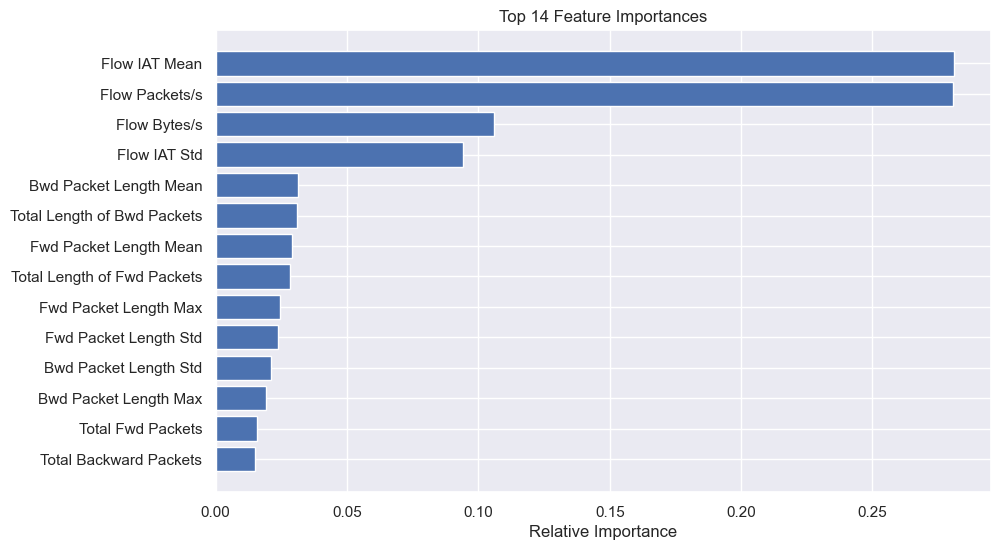

In [35]:
plot_tree_feature(aw_numericalData, aw_numericalData.name, 14)

In [36]:
sw_numericalData = resample_majority(sw_numericalData, (9/1))
sw_numericalData.name = 'Numerical Data for Android_Scareware 90:10 ratio'
has_nan = sw_numericalData.isna().any().any()
has_inf = sw_numericalData.isin([np.inf]).any().any()
print(f"Has NaN values: {has_nan}, Has Inf values: {has_inf}")

Has NaN values: False, Has Inf values: False


Accuracy of Numerical Data for Android_Scareware 90:10 ratio (training set): 0.873 (+/- 0.001)
Top 14 Features:
1. Flow Packets/s: 0.27813721028545707
2. Flow IAT Mean: 0.2775317270365514
3. Flow Bytes/s: 0.10245184982240685
4. Flow IAT Std: 0.09528748243393506
5. Bwd Packet Length Mean: 0.03331422185270111
6. Total Length of Bwd Packets: 0.03246164336215554
7. Fwd Packet Length Mean: 0.030183551626997825
8. Total Length of Fwd Packets: 0.028322475412610786
9. Fwd Packet Length Max: 0.02452036096375409
10. Fwd Packet Length Std: 0.023878223890658072
11. Bwd Packet Length Std: 0.02211416849346827
12. Bwd Packet Length Max: 0.020131918988610706
13. Total Fwd Packets: 0.01623909205516587
14. Total Backward Packets: 0.01542607377552727


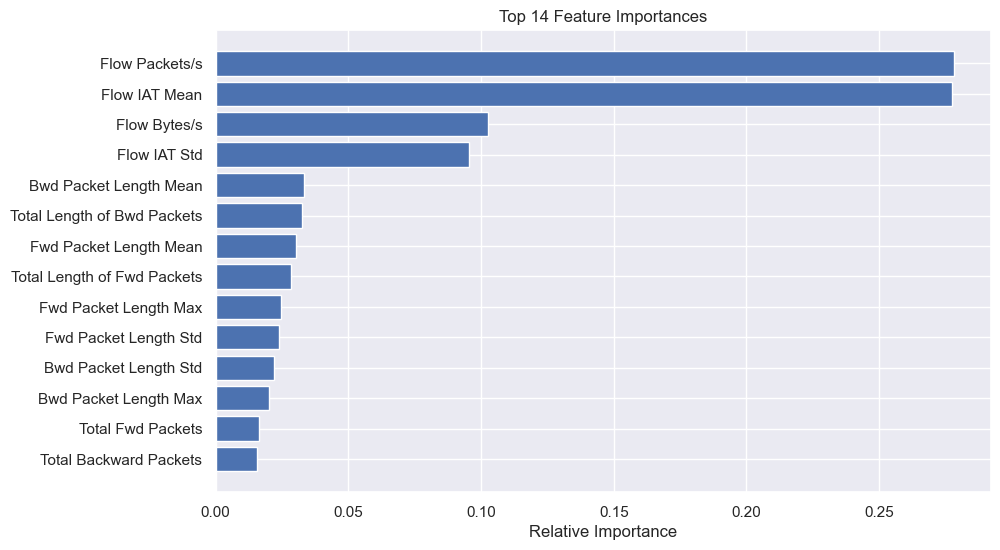

In [37]:
plot_tree_feature(sw_numericalData, sw_numericalData.name, 14)

In [38]:
sms_numericalData = resample_majority(sms_numericalData, (9/1))
sms_numericalData.name = 'Numerical Data for Android_SMS_Malware 90:10 ratio'
has_nan = sms_numericalData.isna().any().any()
has_inf = sms_numericalData.isin([np.inf]).any().any()
print(f"Has NaN values: {has_nan}, Has Inf values: {has_inf}")

Has NaN values: False, Has Inf values: False


Accuracy of Numerical Data for Android_SMS_Malware 90:10 ratio (training set): 0.876 (+/- 0.003)
Top 14 Features:
1. Flow Packets/s: 0.2697449197845376
2. Flow IAT Mean: 0.2689026618308537
3. Flow Bytes/s: 0.0930431773247749
4. Flow IAT Std: 0.08917193307876278
5. Bwd Packet Length Mean: 0.03781979151671367
6. Total Length of Bwd Packets: 0.03738230362679295
7. Fwd Packet Length Mean: 0.034290958857329364
8. Total Length of Fwd Packets: 0.03309532018415767
9. Fwd Packet Length Max: 0.03006161814929007
10. Bwd Packet Length Max: 0.025003854134211606
11. Fwd Packet Length Std: 0.024580631494629836
12. Bwd Packet Length Std: 0.022938482265875866
13. Total Fwd Packets: 0.01806861004087217
14. Total Backward Packets: 0.01589573771119779


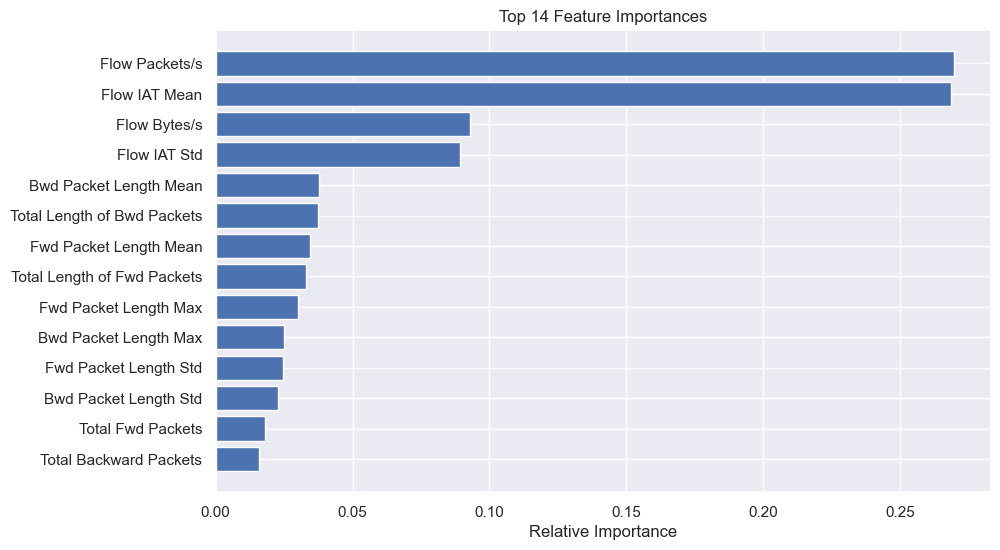

In [39]:
plot_tree_feature(sms_numericalData, sms_numericalData.name, 14)

# 4: Model Classification(RandomForestClassifier) on Categorical DataFrames for the Flag Counts 

In [40]:
aw_cateData = pd.DataFrame(aw_finalData[['FIN Flag Count',
                             'SYN Flag Count',
                             'PSH Flag Count',
                             'ACK Flag Count',
                             'URG Flag Count',
                             'Label']])
sw_cateData = pd.DataFrame(sw_finalData[['FIN Flag Count',
                             'SYN Flag Count',
                             'PSH Flag Count',
                             'ACK Flag Count',
                             'URG Flag Count',
                             'Label']])
sms_cateData = pd.DataFrame(sms_finalData[['FIN Flag Count',
                             'SYN Flag Count',
                             'PSH Flag Count',
                             'ACK Flag Count',
                             'URG Flag Count',
                             'Label']])

In [41]:
aw_cateData = resample_majority(aw_cateData, (9/1))
aw_cateData.name = 'Categorical Data for Android_Adware 90:10 ratio'
has_nan = aw_cateData.isna().any().any()
has_inf = aw_cateData.isin([np.inf]).any().any()
print(f"Has NaN values: {has_nan}, Has Inf values: {has_inf}")

Has NaN values: False, Has Inf values: False


Accuracy of Categorical Data for Android_Adware 90:10 ratio (training set): 0.899 (+/- 0.000)
Top 5 Features:
1. SYN Flag Count: 0.3993303674394987
2. URG Flag Count: 0.33831468687211086
3. ACK Flag Count: 0.2070307421312679
4. PSH Flag Count: 0.03870238745913774
5. FIN Flag Count: 0.016621816097984736


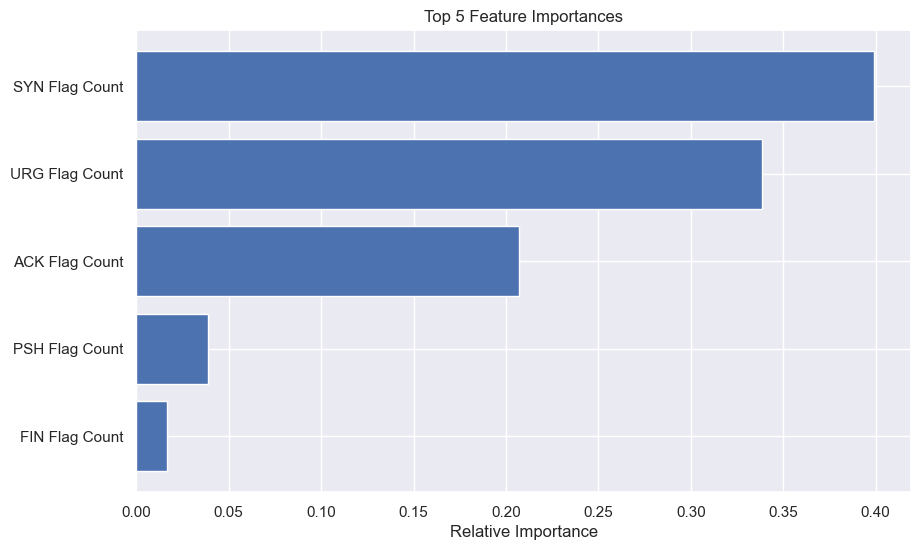

In [42]:
plot_tree_feature(aw_cateData, aw_cateData.name, 5)

In [43]:
sw_cateData = resample_majority(sw_cateData, (9/1))
sw_cateData.name = 'Categorical Data for Android_Scareware 90:10 ratio'
has_nan = sw_cateData.isna().any().any()
has_inf = sw_cateData.isin([np.inf]).any().any()
print(f"Has NaN values: {has_nan}, Has Inf values: {has_inf}")

Has NaN values: False, Has Inf values: False


Accuracy of Categorical Data for Android_Scareware 90:10 ratio (training set): 0.900 (+/- 0.000)
Top 5 Features:
1. SYN Flag Count: 0.3931548699804278
2. URG Flag Count: 0.28906575261062845
3. FIN Flag Count: 0.11200629822658892
4. PSH Flag Count: 0.10323774003094657
5. ACK Flag Count: 0.10253533915140817


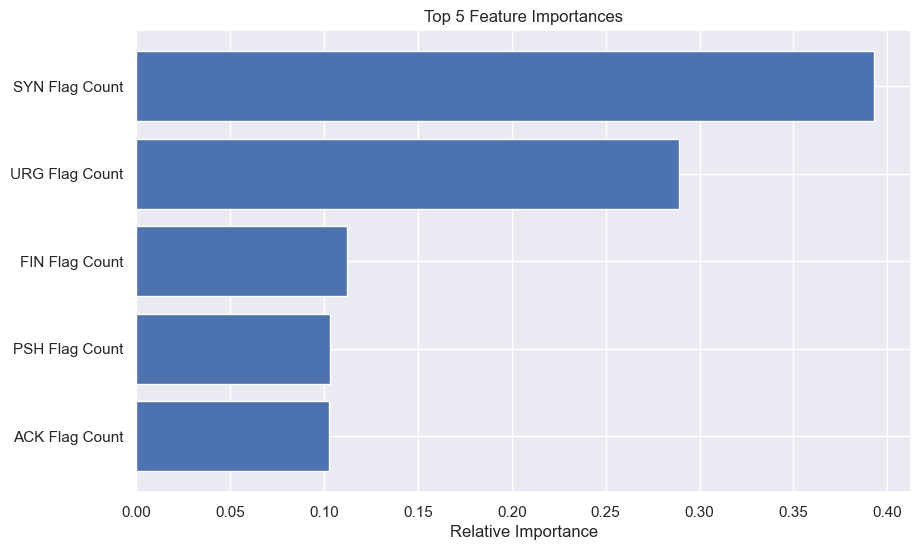

In [44]:
plot_tree_feature(sw_cateData, sw_cateData.name, 5)

In [45]:
sms_cateData = resample_majority(sms_cateData, (9/1))
sms_cateData.name = 'Categorical Data for Android_SMS_Malware 90:10 ratio'
has_nan = sms_cateData.isna().any().any()
has_inf = sms_cateData.isin([np.inf]).any().any()
print(f"Has NaN values: {has_nan}, Has Inf values: {has_inf}")

Has NaN values: False, Has Inf values: False


Accuracy of Categorical Data for Android_SMS_Malware 90:10 ratio (training set): 0.900 (+/- 0.000)
Top 5 Features:
1. SYN Flag Count: 0.3966424014724036
2. PSH Flag Count: 0.2868687767043244
3. ACK Flag Count: 0.15274543719629252
4. URG Flag Count: 0.13198207717123583
5. FIN Flag Count: 0.031761307455743695


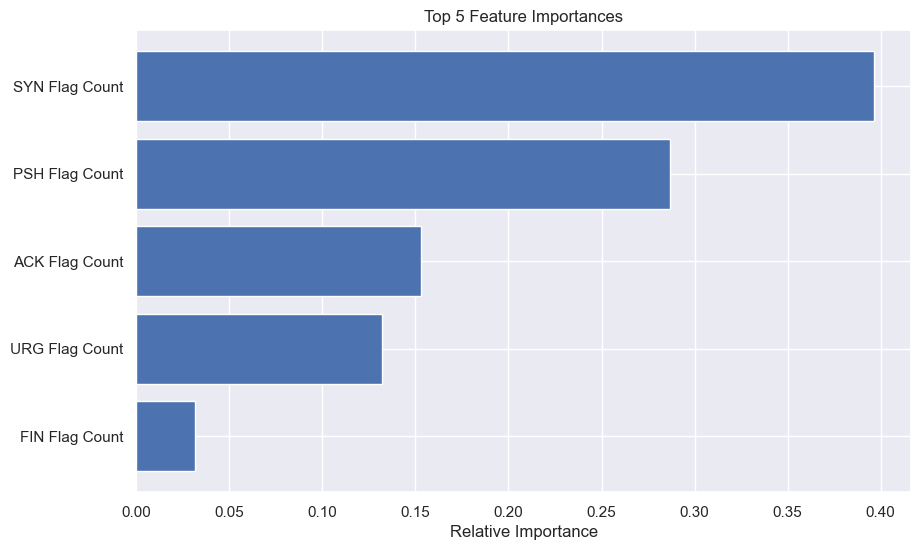

In [46]:
plot_tree_feature(sms_cateData, sms_cateData.name, 5)

# Conclusion: Data driven insights
>Question: What are the variables that help to predict the types of malware attack that happened on an Android device

# 2: Model Classification(RandomForestClassifier) on PCA Dimension reduced Numerical DataFrames:
## For this section, we are able to utilized the functions coded in 1: Functions for Resampling and Random Forest Sampling to enable us to effficiently deduce the best ratio in terms efficiency for reducing computational power required whilst maintain the accuracy due to the Dimension Reduction process in Part 3 of this project.

## We do acknowledge that the Dimension Reduction process on the segmented Dataframes based on data available for Forward Packets, Backward Packets and Flow produces the relatively the same accuracy for the models for all the different dataframes (Given the ratio of data distribution).

## Furthermore, due to the PCA Dimension Reduction process reducing the Datavariables to become Principle Components, we are unable to answer the question this project hopes to answer. 

## Thus Dimension Reduction through PCA can be useful in high dimension scenarios however due to the nature of our dataset we choose as well as the question our group posed, Dimension Reduction just aid us to achieve finding the right ratio for data distribution in terms of efficiency and accuracy.

# 3: Model Classification(RandomForestClassifier) on Numerical DataFrames:
>Along with the accuracy score produced of around 90%, the Visualization of Feature Importance (Random Forest Classifier) allows us to measure the importance of the feature in predicting the variables present when an Android Device is compromised.

>The order of Feature Importance has a consistent order for the Numerical Data throughout all the types of Malware Attacks.
>>1. Flow IAT Mean

>>2. Flow Packets/s

>>3. Flow Bytes/s

>>4. Flow IAT Std

>>5/6. Bwd Packet Length Mean/Total Length of Bwd Packets

>>7/8. Fwd Packet Length Mean/Total Length of Fwd Packets

>>9. Fwd Packet Length Max

>>10. Bwd Packet Length Max

>>11. Fwd Packet Length Std

>>12. Bwd Packet Length Std

>>13. Total Fwd Packets

>>14. Total Backward Packets

## Based on the information provided, we can conclude that the Random Forest Classifier model was able to accurately predict the presence of malware in Android devices with an accuracy score of around 90%. Additionally, the model identified the importance of various numerical features in predicting the presence of malware in the devices.

## The order of feature importance suggests that the mean and standard deviation of flow inter-arrival time (IAT) and the rate of flow packets and bytes are the most important numerical features for predicting the presence of malware. The length of Forward and Backward packets are also important features.

## These insights allow us to create efficient methods for identifying and thwarting malware assaults on Android devices. For instance, security experts can concentrate on keeping an eye on the network traffic and data Flow Data in Android smartphones to spot suspicious behaviour connected to these crucial elements. To increase the accuracy of malware detection on Android devices, they can also create machine learning models like this basic model we created in predicting which variable

# 4: Model Classification(RandomForestClassifier) on Categorical DataFrames for the Flag Counts 
## Along with the accuracy score produced of around 90%, the Visualization of Feature Importance (Random Forest Classifier) allows us to measure the importance of the feature as well as the trends in which different Malware attacks has different triggered flag when a Malware Attack happens.

>Android_Adware order of Feature Importance

>>1. SYN Flag Count: 0.3993303674394987

>>2. URG Flag Count: 0.33831468687211086

>>3. ACK Flag Count: 0.2070307421312679

>>4. PSH Flag Count: 0.03870238745913774

>>5. FIN Flag Count: 0.016621816097984736

>Android_Scareware order of Feature Importance

>>1. SYN Flag Count: 0.3931548699804278

>>2. URG Flag Count: 0.28906575261062845

>>3. FIN Flag Count: 0.11200629822658892

>>4. PSH Flag Count: 0.10323774003094657

>>5. ACK Flag Count: 0.10253533915140817


>Android_SMS_Malware order Feature Importance

>>1. SYN Flag Count: 0.3966424014724036

>>2. PSH Flag Count: 0.2868687767043244

>>3. ACK Flag Count: 0.15274543719629252

>>4. URG Flag Count: 0.13198207717123583

>>5. FIN Flag Count: 0.031761307455743695

>T: AW : SW : SMS

>1: SYN : SYN : SYN

>2: URG : URG : PSH

>3: ACK : FIN : ACK

>4: PSH : PSH : URG

>5: FIN : ACK : FIN

## For SMS malware, the most important feature is the count of SYN flags, followed by PSH, ACK, URG, and FIN flags.

## Comparing the feature importance across the three types of malware, we can see that the count of SYN flags is consistently the most important feature for all three types. The order of importance for other flags varies slightly between the different types of malware.

## This information can be useful in developing effective strategies for detecting and mitigating different types of Android malware. For example, security professionals can focus on monitoring the network traffic for the count of SYN flags to detect potential Adware, Scareware, and SMS malware attacks. They can also develop machine learning models that incorporate these features to improve the accuracy of malware detection in Android devices.

# Conclusion:
## To answer the original question: What are the variables that help to predict the types of malware attack that happened on an Android device?

###  Based on the numerical data and flag data provided in the project, we are able to achieve an accuracy of >90% in predicting the variables that act as indicator for the various types of malware attacks that occurs on an Android device.

###  From the numerical data, we can see that the flow inter-arrival time (IAT) mean and standard deviation, flow packets/s, and flow bytes/s are important features for predicting the presence of malware in Android devices, regardless of the type of malware. These Numerical Variables are good indicator if the Android Device is currently suffering from a Malware Attack.

###  Coupled with the insights from thte flag data, we can see that the count of SYN, URG, ACK, PSH, and FIN flags are important features for predicting the presence of Adware, Scareware, and SMS malware attacks. The order of importance for these flags varies slightly between the different types of malware, which can help enable us to utilize them to also predict what type of Malware Attack has occurer on the Android Device.

### Overall, combining the numerical data and flag data, we can draw the conclusion that the flow IAT mean and standard deviation, flow packets/s, and flow bytes/s are significant features for predicting the presence of malware in Android devices, whereas the count of SYN, URG, ACK, PSH, and FIN flags are significant features for predicting the presence of particular types of malware attacks. Leveraging on these findings, they may be aid us if we were to now set out to create a machine learning models for Android device malware prediction, allowing for more precise and efficient mitigation of Android Malware Attacks.